## Import package

In [1]:
import sys
sys.path.append('./script')
# import ETGEMs_function_protain as etgf
from pyomo_solving import *
from ET_optme import *
import pandas as pd
import cobra
import gurobipy
import json
import multiprocessing
import os
from multiprocessing import Pool
from tqdm import tqdm 
from sympy import subsets
import pandas as pd
import matplotlib.pyplot as plt
import re



## setting path for models and data, Example: using C.glutamicum to produce L_Lysine

In [2]:
# data 
model_file="./file/iCW773_irr_enz_constraint_adj_PDH_irr.json" # c.glutamicum model, irreversible and reactions with isoezyme splited
reaction_kcat_MW_file='./file/reaction_change_by_enzuse_PDH_n.csv'
# results
path_results = './results/lysine'
savepath = './results/picture'
dictionarymodel_path='./file/dictionarymodel_iCW.json' # dictionary model saving path

wild_enzyme_concentration_path = './results/ET-EComp/lysine/wild-enzyme.json'
over_enzyme_concentration_path = './results/ET-EComp/lysine/over-enzyme.json'
# case study
model0_file = './file/iCW773_uniprot_modification_del.json'
reaction_g0_file=os.path.join('./file/iCW773_uniprot_modification_del_reaction_g0.csv') #  standard Gibbs free energy files 
metabolites_lnC_file = os.path.join('./file/metabolites_lnC_cg1.txt') # concentration range files

## Setting task, prepare task.json

In [3]:
# model、substrate、product、oxygence
# mode: SET-->Enzyme-Thermo constrained, mode: SE-->Enzyme constrained, mode: ST-->Thermo constrained,mode: S-->Stoichiometric constrained  
inputdic = {"model":'iCW773_irr_enz_constraint_adj_PDH_irr.json',
"substrate":"EX_glc_e_reverse",
"biomass": "CG_biomass_cgl_ATCC13032",
"product": "EX_lys_L_e",
"taskname": "optforce",
"mode":"SET",
"oxygenstate":"aerobic"}
# save task.json
with open('./results/task.json', 'w') as json_file:
    json.dump(inputdic, json_file, indent=4)
path_strain = 'iCW'

## Invoke ET-OptME and run the task 

## 1.Enzyme-thermo model construction

In [4]:
# read model
model = cobra.io.load_json_model(model_file)

# Store model data into Get_Concretemodel_Need_Data
Concretemodel_Need_Data = Get_Concretemodel_Need_Data(model_file)

model0 = cobra.io.load_json_model(model0_file)

# Save the protein-centered model as a dictionary
dictionary_model = json_load(dictionarymodel_path)
dictionary_model.keys()

rname3 = []

# Store the protein-centered dictionary into Get_Concretemodel_Need_Data
get_dictionarymodel_data2(dictionary_model, Concretemodel_Need_Data, rname3)

# Store thermodynamic data into Get_Concretemodel_Need_Data
Get_Concretemodel_Need_Data_g0(Concretemodel_Need_Data, reaction_g0_file, metabolites_lnC_file, reaction_kcat_MW_file)

Concretemodel_Need_Data['reaction_g0']['g0'] = Concretemodel_Need_Data['reaction_g0']['g0'].replace(0, np.nan)
Concretemodel_Need_Data['reaction_g0'].dropna(subset=['g0'], inplace=True)

Concretemodel_Need_Data['reaction_g0'].at['AIRC3_reverse', 'g0'] = 0
Concretemodel_Need_Data['reaction_g0'].at['ATPS4rpp_reverse_num2', 'g0'] = 0

Inc = Concretemodel_Need_Data['metabolites_lnC']

for i in Concretemodel_Need_Data['metabolite_list']:
    if i not in Inc.index:
        Inc.loc[i, 'lnClb'] = -14.508658
        Inc.loc[i, 'lnCub'] = -3.912023

Concretemodel_Need_Data['metabolites_lnC'] = Inc

# Modify the oxygen conditions of the model
if inputdic['oxygenstate'] == 'aerobic':
    model.reactions.get_by_id('EX_o2_e_reverse').upper_bound = 1000
if inputdic['oxygenstate'] == 'micro_aerobic': 
    model.reactions.get_by_id('EX_o2_e_reverse').upper_bound = 2 
if inputdic['oxygenstate'] == 'anaerobic': 
    model.reactions.get_by_id('EX_o2_e_reverse').upper_bound = 0



Set parameter Username
Academic license - for non-commercial use only - expires 2099-12-31


## 2.Algorithm :  ET-EComp

In [5]:
# Calculate the maximum growth rate
B_value1,v0_biomass,bio,totalE1,objvalue2 = calculate_biomass(Concretemodel_Need_Data,inputdic,model,'iCW')

maximum growth rate value is: 0.42872386022140385(mmol/gDW/h)
The maximum thermodynamic driving force value is : 0.42872386022140385
minimizing the total enzyme concentration  is: 0.12116777451903912((mmol/gDW)


In [6]:
# Calculate the enzyme concentration range under maximum growth conditions
enzyme_list = list(Concretemodel_Need_Data['mw_dict'].keys()) 
obj_names = enzyme_list
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

# Use multiprocessing to calculate the wild range for each enzyme
results = pool.starmap(calculate_wildrange, [(Concretemodel_Need_Data, obj_name, inputdic, objvalue2, v0_biomass, totalE1, path_strain, B_value1) for obj_name in obj_names])

pool.close()
pool.join()

# Combine the results into a final dictionary
final_results = {}
for result in results:
    final_results.update(result)


Read LP format model from file /tmp/tmpxkzulrr4.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpwk60dfdl.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpk1hztw_p.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpcyexjfy2.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmphpe3sn35.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp82px0m9q.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpyt1ddk_b.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp76b75vt0.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp1

In [7]:

# Save the results as a JSON file
wild_file_path = os.path.join(wild_enzyme_concentration_path)
with open(wild_file_path, 'w') as json_file:
    json.dump(final_results, json_file)

In [8]:
# Calculate the maximum production rate
B_value2,v1_product_max,pro,totalE2,EcoECM_FBA_protainmodel_B2 = calculate_product(Concretemodel_Need_Data,inputdic,objvalue2,path_strain,v0_biomass)

maximum growth rate value is: 2.8851125329282814(mmol/gDW/h)
The maximum thermodynamic driving force value is : 2.8851125329282814
minimizing the total enzyme concentration  is: 0.07595477127049449((mmol/gDW)


In [9]:
# The enzymes that catalyze each reaction in the model
enzyme_list = list(Concretemodel_Need_Data['mw_dict'].keys()) 
obj_names = enzyme_list
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

results = pool.starmap(calculate_over, [(Concretemodel_Need_Data,obj_name,inputdic,objvalue2,v0_biomass,v1_product_max,totalE2,path_strain,B_value2) for obj_name in obj_names])
pool.close()
pool.join()


final_results = {}
for result in results:
    final_results.update(result)
over_file_path = os.path.join(over_enzyme_concentration_path)
with open(over_file_path, 'w') as json_file:
    json.dump(final_results, json_file)

Read LP format model from file /tmp/tmpgrtplwdb.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp96g441p5.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmprjtt26j9.lp
Reading time = 0.01 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp_colxpg3.lp
Read LP format model from file /tmp/tmp4e9kzea7.lp
Reading time = 0.05 seconds
Reading time = 0.05 seconds
: 949 rows, 3704 columns, 15400 nonzeros
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmp47j6ucx5.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmppddytwny.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpfpy_m3lg.lp
Reading time = 0.02 seconds
: 949 rows, 3704 columns, 15400 nonzeros
Read LP format model from file /tmp/tmpm

## 3. process results

In [10]:
path_results='./results/ET-EComp/lysine'

In [11]:
#Read results file
enzyme_results_data,enzyme_overresults2_data = read_file(path_results)

In [12]:
# Filter the targets that need modification
ko_data,up_data,down_data = compare_results(enzyme_results_data, enzyme_overresults2_data,inputdic)

In [13]:
# get reaction equation
reaction_list=Concretemodel_Need_Data['e0']
equation_dict = gene_reaction_map1(reaction_list,model)

In [14]:
# Enzyme concentrations and flux distribution under the wild-type condition
E_refdict, mw_dict, reaction_dict_bio, kcat_dict = ref_e_con(inputdic, Concretemodel_Need_Data, totalE1, path_strain, objvalue2)


0.40728766720555415


In [15]:
# Retrieve gene, equation, and reaction mappings
new_gene_reaction_mapping_bio, gene_reaction_mapping, gene_kcat_mapping = gene_reaction_map(enzyme_list, reaction_dict_bio, kcat_dict, Concretemodel_Need_Data, model)


In [16]:
# Retrieve the reaction flux distribution under maximum production conditions
reaction_dict, kcat_dict, EcoECM_FBA_protainmodel_pro_max = reaction_flux(inputdic, Concretemodel_Need_Data, totalE2, path_strain, totalE1, objvalue2, v0_biomass)

2.740864922456977


In [17]:
# Retrieve the enzyme concentrations and corresponding reaction flux distributions for the overexpressed state
new_gene_reaction_mapping, gene_reaction_mapping, gene_kcat_mapping = gene_reaction_map(enzyme_list, reaction_dict, kcat_dict, Concretemodel_Need_Data, model)

In [18]:
# Retrieve the enzyme usage proportions for each enzyme in the model
normalized_E_dict, E_dict, e_dict = enzyme_usage_over(EcoECM_FBA_protainmodel_pro_max, Concretemodel_Need_Data)


sum: 0.07595477128887684


In [19]:
# Calculate the adjustment level for each modification strategy
Fold_change = fold_change(E_dict, E_refdict)

In [20]:
# List of all reactions in the model
reaction_list = []
for rea in model.reactions:
    reaction_list.append(rea.id)

In [21]:
# Retrieve the reaction equations
equation_dict = gene_reaction_map1(reaction_list, model)

In [22]:
# Generate the result table (modification strategies, equations, adjustment levels, enzyme proportions, etc.)
# Set a threshold to retain only strategies for reactions catalyzed by enzymes with flux > 0.1 mmol/gDW/h in either the wild-type or overexpression type.
meged_df = must_df(inputdic, equation_dict, new_gene_reaction_mapping_bio, new_gene_reaction_mapping, E_refdict, E_dict, Fold_change, normalized_E_dict, e_dict, gene_kcat_mapping, enzyme_results_data, enzyme_overresults2_data, ko_data, up_data, down_data, Concretemodel_Need_Data)


In [23]:
# Overflow reactions in the model for wild and overexpressed states, along with biomass and product B value
bio_df, pro_df, KeyInfo = basic(bio, pro, B_value1, v0_biomass, B_value2, v1_product_max, totalE1, totalE2, inputdic)


In [24]:
# Identify bottleneck reactions under thermodynamic constraints
bottleneck_reactions_list, Df = bottleneck_reactions(EcoECM_FBA_protainmodel_B2, model)


In [25]:
# Generate the result table
output(KeyInfo,path_results,bio_df,pro_df,meged_df,inputdic,Df)

In [26]:
# read xlsx file
optforce_lys = pd.read_excel('./results/ET-EComp/lysine/results.xlsx', sheet_name='MUST')

In [27]:
# Filter reactions with manipulations labeled as UP
optforce_lys_up = optforce_lys[optforce_lys['manipulations'] == 'Up']



In [28]:
# Filter reactions with manipulations labeled as down
optforce_lys_down = optforce_lys[optforce_lys['manipulations'] == 'down']


In [29]:
# Filter reactions with manipulations labeled as Up
optforce_lys_up = optforce_lys[optforce_lys['manipulations'] == 'Up']
optforce_lys_up

# Find enzyme names through GPR relationships
import pandas as pd

# Read the TSV file
tsv_data = pd.read_csv('./file/gene_overview_init.tsv', delimiter='\t')

all = {}
# Process each value
for genes in optforce_lys_up['gene']:
    gene_ids = genes.split(' and ') if isinstance(genes, str) else []
    gene_names = []
    for gene in gene_ids:
        matches = tsv_data[tsv_data['Cgl_ID'] == gene]
        if not matches.empty:
            gene_name = str(matches.iloc[0]['Gene_Name'])
            gene_names.append(gene_name)
        else:
            gene_names.append('None')  # If no corresponding Gene_Name is found, set it to the string 'None' or another appropriate default value
    combined_names = ', '.join(gene_names)
    all[genes] = combined_names

optforce_lys_up['enzyme'] = optforce_lys_up['gene'].map(all)


/tmp/ipykernel_1990532/2855523880.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optforce_lys_up['enzyme'] = optforce_lys_up['gene'].map(all)


In [30]:
# Filter reactions with manipulations labeled as down
optforce_lys_down = optforce_lys[optforce_lys['manipulations'] == 'down']
optforce_lys_down

# Find enzyme names through GPR relationships
import pandas as pd

# Read the TSV file
tsv_data = pd.read_csv('./file/gene_overview_init.tsv', delimiter='\t')

all = {}
# Process each value
for genes in optforce_lys_down['gene']:  # Corrected to use optforce_lys_down
    gene_ids = genes.split(' and ') if isinstance(genes, str) else []
    gene_names = []
    for gene in gene_ids:
        matches = tsv_data[tsv_data['Cgl_ID'] == gene]
        if not matches.empty:
            gene_name = str(matches.iloc[0]['Gene_Name'])
            gene_names.append(gene_name)
        else:
            gene_names.append('None')  # If no corresponding Gene_Name is found, set it to the string 'None' or another appropriate default value
    combined_names = ', '.join(gene_names)
    all[genes] = combined_names

optforce_lys_down['enzyme'] = optforce_lys_down['gene'].map(all)


/tmp/ipykernel_1990532/2820677211.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optforce_lys_down['enzyme'] = optforce_lys_down['gene'].map(all)


In [31]:
filename=os.path.join('./results/results.xlsx')
with pd.ExcelWriter(filename) as writer:
    optforce_lys.to_excel(writer,sheet_name='MUST',index=True)
    optforce_lys_down.to_excel(writer,sheet_name='down',index=True)
    optforce_lys_up.to_excel(writer,sheet_name='up',index=True)

## Analyze ET-OptForce results
## Case Studies

In [32]:
lysine_S = pd.read_excel('./results/ET-EComp/lysine/S_lys/results.xlsx',sheet_name='MUST')
lysine_ST = pd.read_excel('./results/ET-EComp/lysine/T_lys/results.xlsx',sheet_name='MUST')
lysine_SE = pd.read_excel('./results/ET-EComp/lysine/E_lys/results.xlsx',sheet_name='MUST')
lysine_SET = pd.read_excel('./results/ET-EComp/lysine/ET_lys/results.xlsx',sheet_name='MUST')

In [33]:
lysine_SET = lysine_SET.drop('Unnamed: 0', axis=1)
lysine_S = lysine_S.drop('Unnamed: 0', axis=1)
lysine_ST = lysine_ST.drop('Unnamed: 0', axis=1)
lysine_SE = lysine_SE.drop('Unnamed: 0', axis=1)

In [34]:
pyrc = lysine_S[lysine_S['reaction']=='PYRC']
ASPK = lysine_S[lysine_S['reaction']=='ASPK']
IPPS = lysine_S[lysine_S['reaction']=='IPPS']
GAPD = lysine_S[lysine_S['reaction']=='GAPD_num1']

In [35]:
pyrc = pyrc.iloc[:, :4]
ASPK = ASPK.iloc[:, :4]
IPPS = IPPS.iloc[:, :4]
GAPD = GAPD.iloc[:, :4]
S_result_pyrc = {}
S_result_aspk = {}
S_result_ipps = {}
S_result_gapd = {}
for index, row in pyrc.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    s_temp_dict_pyrc = {"id":"OptForce","reaction": 'PYRC:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    S_result_pyrc[reaction_name] = s_temp_dict_pyrc
for index, row in ASPK.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    s_temp_dict_aspk = {"id":"OptForce","reaction":'ASPK:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    S_result_aspk[reaction_name] = s_temp_dict_aspk

for index, row in IPPS.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    s_temp_dict_ipps = {"id":"OptForce","reaction": 'IPPS:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    S_result_ipps[reaction_name] = s_temp_dict_ipps
for index, row in GAPD.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    s_temp_dict_gapd = {"id":"OptForce","reaction": 'GAPD:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    S_result_gapd[reaction_name] = s_temp_dict_gapd

In [36]:
tdf_pyrc = lysine_ST[lysine_ST['reaction']=='PYRC']
tdf_aspk = lysine_ST[lysine_ST['reaction']=='ASPK']
tdf_ipps = lysine_ST[lysine_ST['reaction']=='IPPS']
tdf_gapd = lysine_ST[lysine_ST['reaction']=='GAPD']

In [37]:


tdf_pyrc = tdf_pyrc.iloc[:, :4]
tdf_aspk = tdf_aspk.iloc[:, :4]
tdf_ipps = tdf_ipps.iloc[:, :4]
tdf_gapd = tdf_gapd.iloc[:, :4]
T_result_pyrc = {}
T_result_aspk = {}
T_result_ipps = {}
T_result_gapd = {}
for index, row in tdf_pyrc.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    T_result_dict_pyrc = {"id":"T_OptForce","reaction":'PYRC:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    T_result_pyrc[reaction_name] = T_result_dict_pyrc
for index, row in tdf_aspk.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    T_result_dict_aspk = {"id":"T_OptForce","reaction":'ASPK:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    T_result_aspk[reaction_name] = T_result_dict_aspk

for index, row in tdf_ipps.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    T_result_dict_ipps = {"id":"T_OptForce","reaction":'IPPS:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    T_result_ipps[reaction_name] = T_result_dict_ipps
for index, row in tdf_gapd.iterrows():
    reaction_name = row['reaction']
    equation = row['equation']
    flux_wild_values = [float(value.strip("'")) for value in row['flux_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['flux_over'].strip('[]').split(', ')]
    T_result_dict_gapd = {"id":"T_OptForce","reaction":'GAPD:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    T_result_gapd[reaction_name] = T_result_dict_gapd

In [38]:
ecdf_pyrc = lysine_SE[lysine_SE['reaction']=='PYRC']
ecdf_aspk = lysine_SE[lysine_SE['reaction']=='ASPK']
ecdf_ipps = lysine_SE[lysine_SE['reaction']=='IPPS']
ecdf_gapd = lysine_SE[lysine_SE['gene']=='Cgl0937']

In [39]:
E_result_dict_pyrc = {}
E_result_dict_aspk = {}
E_result_dict_ipps = {}
E_result_dict_gapd = {}


for index, row in ecdf_pyrc.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    ec_temp_dict_pyrc = {"id":"EC_EComp","reaction":'Cgl0689:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    reaction = ec_temp_dict_pyrc['reaction']

    reaction_cleaned = reaction.split('(', 1)[0].strip() + " : " + reaction.split(':', 1)[1].split(':', 1)[1].strip()

    ec_temp_dict_pyrc['reaction'] = reaction_cleaned
    E_result_dict_pyrc[reaction_name] = ec_temp_dict_pyrc
for index, row in ecdf_aspk.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    ec_temp_dict_aspk = {"id":"EC_EComp","reaction":'Cgl0251:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}
    reaction = ec_temp_dict_aspk['reaction']

    reaction_cleaned = reaction.split('(', 1)[0].strip() + " : " + reaction.split(':', 1)[1].split(':', 1)[1].strip()

    ec_temp_dict_aspk['reaction'] = reaction_cleaned    
    E_result_dict_aspk[reaction_name] = ec_temp_dict_aspk

for index, row in ecdf_ipps.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    ec_temp_dict_ipps = {"id":"EC_EComp","reaction":'Cgl0248:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}
    reaction = ec_temp_dict_ipps['reaction']

    reaction_cleaned = reaction.split('(', 1)[0].strip() + " : " + reaction.split(':', 1)[1].split(':', 1)[1].strip()

    ec_temp_dict_ipps['reaction'] = reaction_cleaned    
    E_result_dict_ipps[reaction_name] = ec_temp_dict_ipps


for index, row in ecdf_gapd.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    ec_temp_dict_gapd = {"id":"EC_EComp","reaction":'Cgl0937:'+'g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c' , "wild_range": flux_wild_values, "eng_range": flux_over_values}
    reaction = ec_temp_dict_gapd['reaction']
    ec_temp_dict_ipps['reaction'] = reaction_cleaned    
    E_result_dict_ipps[reaction_name] = ec_temp_dict_ipps

In [40]:
edf_pyrc = lysine_SET[lysine_SET['reaction']=='PYRC']
edf_aspk = lysine_SET[lysine_SET['reaction']=='ASPK']
edf_ipps = lysine_SET[lysine_SET['reaction']=='IPPS']
edf_gapd = lysine_SET[lysine_SET['gene']=='Cgl0937']

In [41]:
ET_result_dict_pyrc = {}
ET_result_dict_aspk = {}
ET_result_dict_ipps = {}
ET_result_dict_gapd = {}


for index, row in edf_pyrc.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    et_temp_dict_pyrc = {"id":"ET_EComp","reaction":'Cgl0689:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}

    reaction = et_temp_dict_pyrc['reaction']


    reaction_cleaned = reaction.split('(', 1)[0].strip() + " : " + reaction.split(':', 1)[1].split(':', 1)[1].strip()

    et_temp_dict_pyrc['reaction'] = reaction_cleaned
    ET_result_dict_pyrc[reaction_name] = et_temp_dict_pyrc
for index, row in edf_aspk.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    et_temp_dict_aspk = {"id":"ET_EComp","reaction":'Cgl0251:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}
    reaction = et_temp_dict_aspk['reaction']

    reaction_cleaned = reaction.split('(', 1)[0].strip() + " : " + reaction.split(':', 1)[1].split(':', 1)[1].strip()

    et_temp_dict_aspk['reaction'] = reaction_cleaned    
    ET_result_dict_aspk[reaction_name] = et_temp_dict_aspk

for index, row in edf_ipps.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    et_temp_dict_ipps = {"id":"ET_EComp","reaction":'Cgl0248:'+ equation, "wild_range": flux_wild_values, "eng_range": flux_over_values}
    reaction = et_temp_dict_ipps['reaction']

    reaction_cleaned = reaction.split('(', 1)[0].strip() + " : " + reaction.split(':', 1)[1].split(':', 1)[1].strip()


    et_temp_dict_ipps['reaction'] = reaction_cleaned    
    ET_result_dict_ipps[reaction_name] = et_temp_dict_ipps


for index, row in edf_gapd.iterrows():
    reaction_name = row['gene']
    equation = row['reaction_bio']
    flux_wild_values = [float(value.strip("'")) for value in row['enzyme_wild'].strip('[]').split(', ')]
    flux_over_values = [float(value.strip("'")) for value in row['enzyme_over'].strip('[]').split(', ')]
    et_temp_dict_gapd = {"id":"ET_EComp","reaction":'Cgl0937:'+'g3p_c + nad_c + pi_c --> 13dpg_c + h_c + nadh_c' , "wild_range": flux_wild_values, "eng_range": flux_over_values}
    reaction = et_temp_dict_gapd['reaction']



    et_temp_dict_ipps['reaction'] = reaction_cleaned    
    ET_result_dict_ipps[reaction_name] = et_temp_dict_ipps

## Case Study of Algorithm Advantages

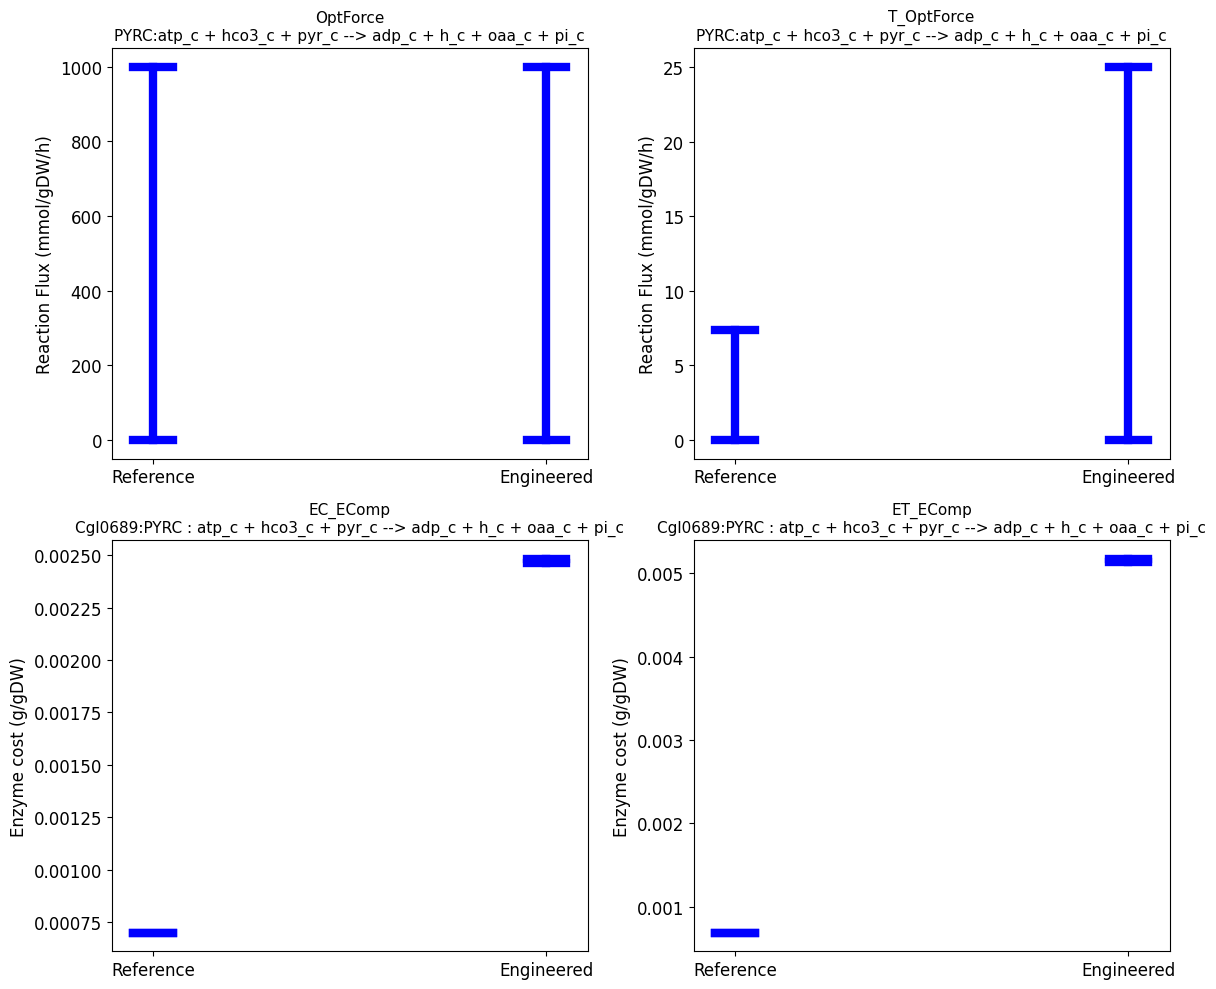

In [42]:
import matplotlib.pyplot as plt
import os


savepath = './figures'
os.makedirs(savepath, exist_ok=True)

data = [
    s_temp_dict_pyrc,
    T_result_dict_pyrc,
    ec_temp_dict_pyrc,
    et_temp_dict_pyrc
]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (ax, item) in enumerate(zip(axes, data)):
    id = item['id']
    reaction = item['reaction']
    ranges = {
        'Reference': item['wild_range'],
        'Engineered': item['eng_range']
    }

    for i, (label, (start, end)) in enumerate(ranges.items()):
        start, end = float(start), float(end)
        ax.plot([i, i], [start, end], color='blue', linewidth=6)
        ax.plot([i - 0.05, i + 0.05], [start, start], color='blue', linewidth=6)
        ax.plot([i - 0.05, i + 0.05], [end, end], color='blue', linewidth=6)

    ax.set_xticks(range(len(ranges)))
    ax.set_xticklabels(list(ranges.keys()), fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    if idx < 2:
        ax.set_ylabel('Reaction Flux (mmol/gDW/h)', fontsize=12)
    else:
        ax.set_ylabel('Enzyme cost (g/gDW)', fontsize=12)

    ax.set_title(id + "\n" + reaction, fontsize=11)
    ax.grid(False)

plt.tight_layout()
plt.savefig(os.path.join(savepath, 'optforce_pyrc_4plots.svg'))
plt.show()


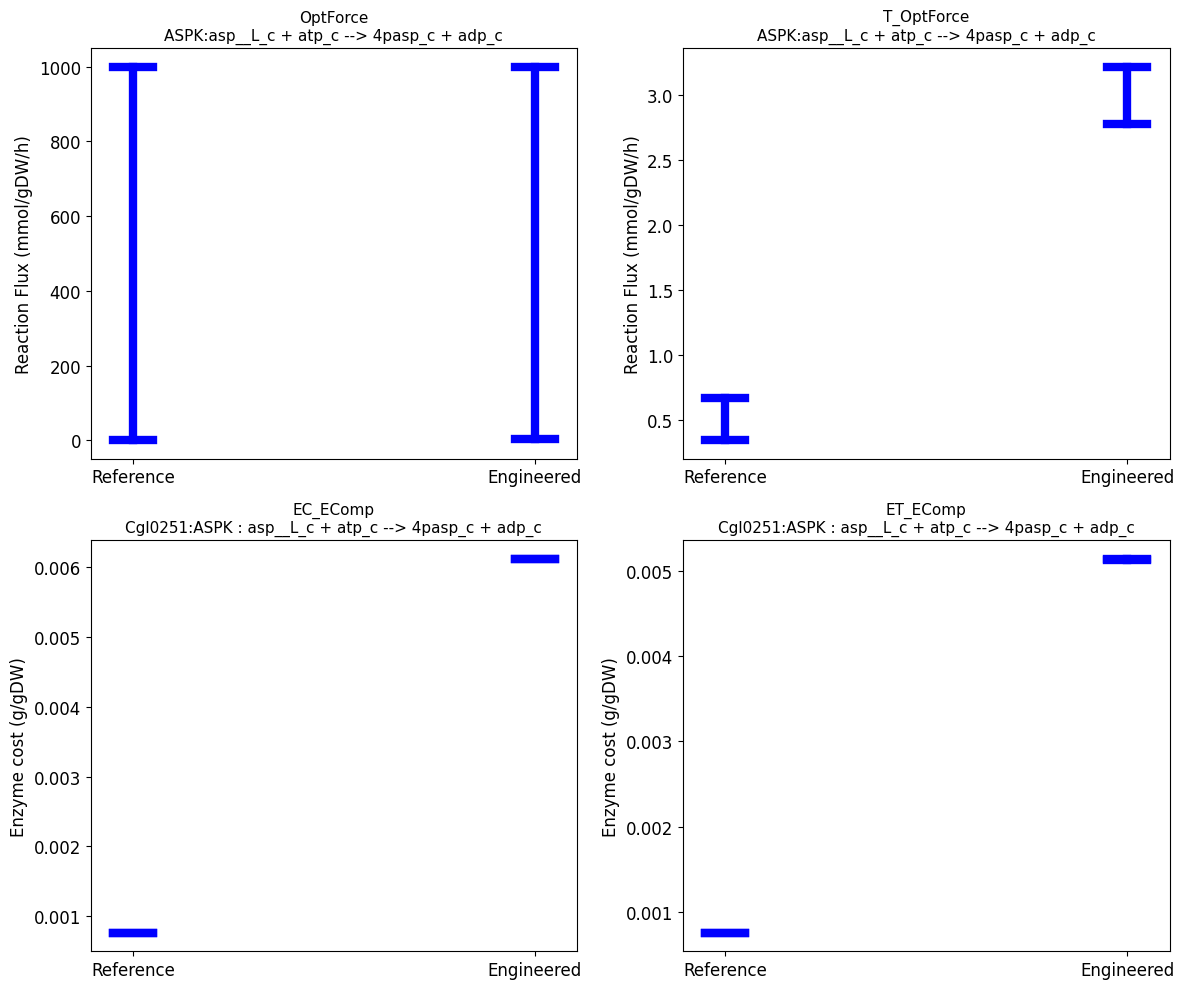

In [43]:
import matplotlib.pyplot as plt
import os

savepath = './figures'
os.makedirs(savepath, exist_ok=True)


data = [
    s_temp_dict_aspk,
    T_result_dict_aspk,
    ec_temp_dict_aspk,
    et_temp_dict_aspk
]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  

for idx, (ax, item) in enumerate(zip(axes, data)):
    id = item['id']
    reaction = item['reaction']
    ranges = {
        'Reference': item['wild_range'],
        'Engineered': item['eng_range']
    }

    for i, (label, (start, end)) in enumerate(ranges.items()):
        start, end = float(start), float(end)
        ax.plot([i, i], [start, end], color='blue', linewidth=6)
        ax.plot([i - 0.05, i + 0.05], [start, start], color='blue', linewidth=6)
        ax.plot([i - 0.05, i + 0.05], [end, end], color='blue', linewidth=6)

    ax.set_xticks(range(len(ranges)))
    ax.set_xticklabels(list(ranges.keys()), fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    if idx < 2:
        ax.set_ylabel('Reaction Flux (mmol/gDW/h)', fontsize=12)
    else:
        ax.set_ylabel('Enzyme cost (g/gDW)', fontsize=12)

    ax.set_title(id + "\n" + reaction, fontsize=11)
    ax.grid(False)

plt.tight_layout()
plt.savefig(os.path.join(savepath, 'optforce_aspk_4plots.svg'))
plt.show()


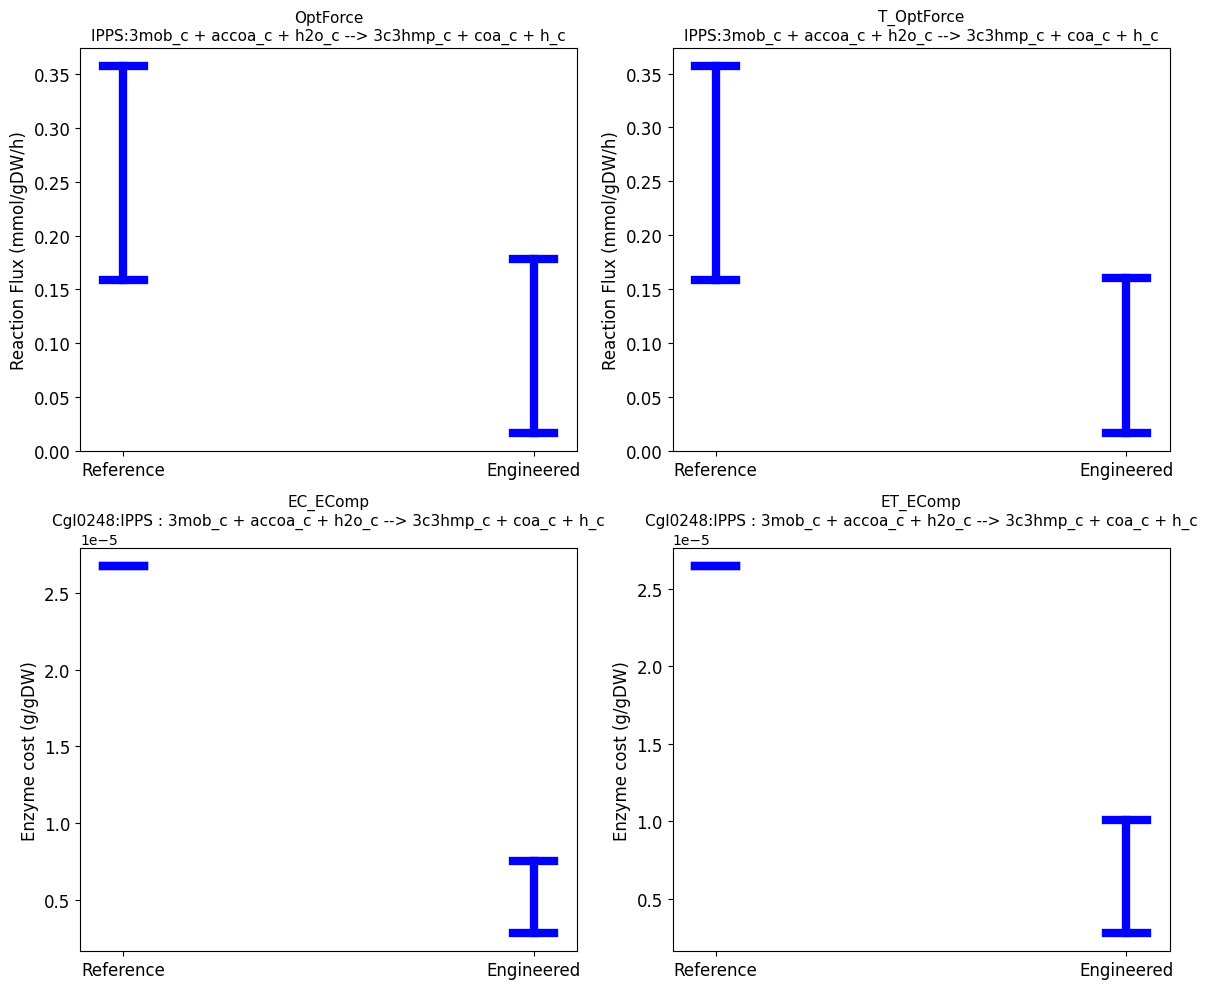

In [44]:
import matplotlib.pyplot as plt
import os


savepath = './figures'
os.makedirs(savepath, exist_ok=True)


data = [
    s_temp_dict_ipps,
    T_result_dict_ipps,
    ec_temp_dict_ipps,
    et_temp_dict_ipps
]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() 
for idx, (ax, item) in enumerate(zip(axes, data)):
    id = item['id']
    reaction = item['reaction']
    ranges = {
        'Reference': item['wild_range'],
        'Engineered': item['eng_range']
    }

    for i, (label, (start, end)) in enumerate(ranges.items()):
        start, end = float(start), float(end)
        ax.plot([i, i], [start, end], color='blue', linewidth=6)
        ax.plot([i - 0.05, i + 0.05], [start, start], color='blue', linewidth=6)
        ax.plot([i - 0.05, i + 0.05], [end, end], color='blue', linewidth=6)

    ax.set_xticks(range(len(ranges)))
    ax.set_xticklabels(list(ranges.keys()), fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    if idx < 2:
        ax.set_ylabel('Reaction Flux (mmol/gDW/h)', fontsize=12)
    else:
        ax.set_ylabel('Enzyme cost (g/gDW)', fontsize=12)

    ax.set_title(id + "\n" + reaction, fontsize=11)
    ax.grid(False)

plt.tight_layout()
plt.savefig(os.path.join(savepath, 'optforce_ipps_4plots.svg'))
plt.show()


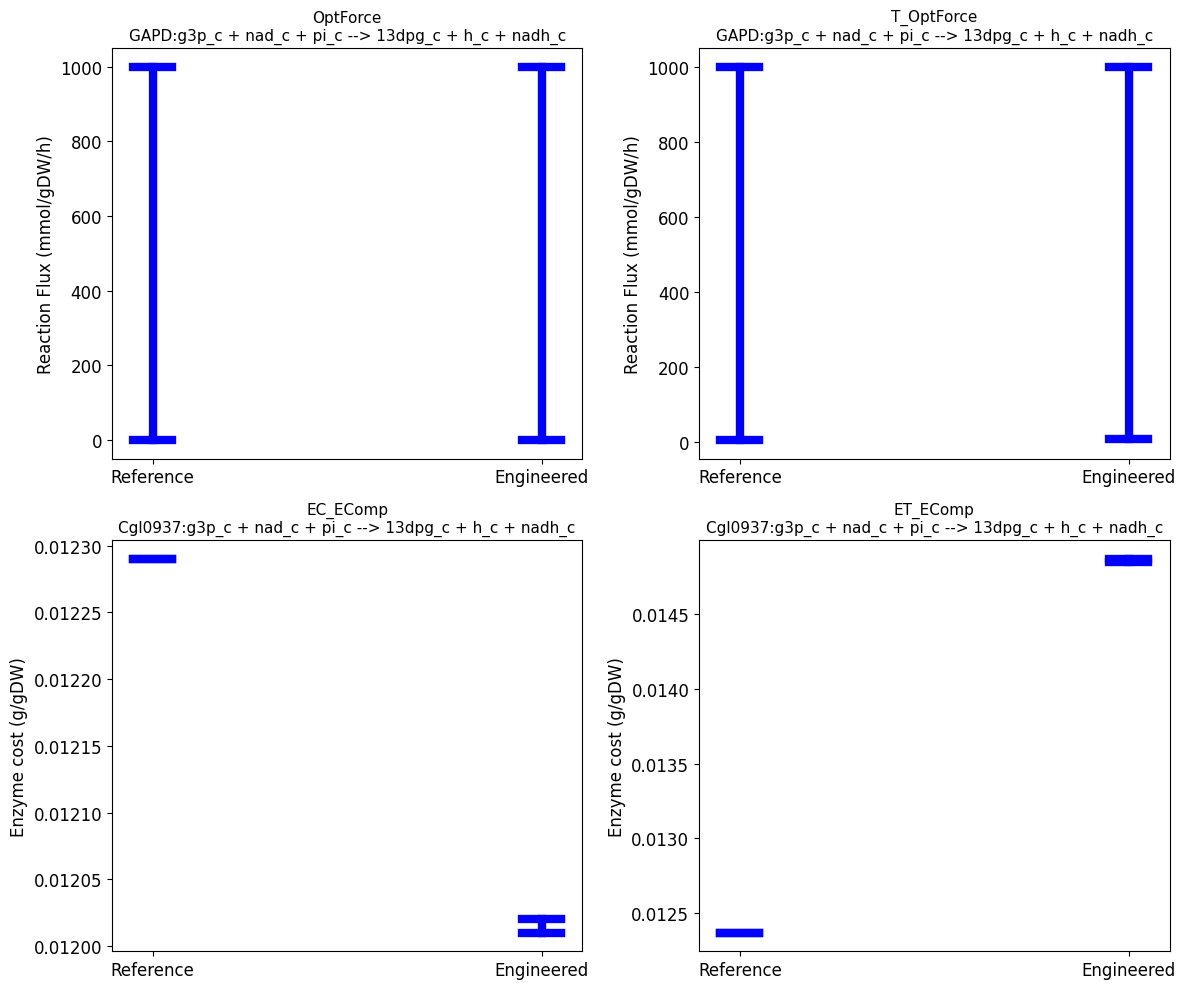

In [45]:
import matplotlib.pyplot as plt
import os


savepath = './figures'
os.makedirs(savepath, exist_ok=True)


data = [
    s_temp_dict_gapd,
    T_result_dict_gapd,
    ec_temp_dict_gapd,
    et_temp_dict_gapd
]


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  

for idx, (ax, item) in enumerate(zip(axes, data)):
    id = item['id']
    reaction = item['reaction']
    ranges = {
        'Reference': item['wild_range'],
        'Engineered': item['eng_range']
    }

    for i, (label, (start, end)) in enumerate(ranges.items()):
        start, end = float(start), float(end)
        ax.plot([i, i], [start, end], color='blue', linewidth=6)
        ax.plot([i - 0.05, i + 0.05], [start, start], color='blue', linewidth=6)
        ax.plot([i - 0.05, i + 0.05], [end, end], color='blue', linewidth=6)

    ax.set_xticks(range(len(ranges)))
    ax.set_xticklabels(list(ranges.keys()), fontsize=12)
    ax.tick_params(axis='y', labelsize=12)

    if idx < 2:
        ax.set_ylabel('Reaction Flux (mmol/gDW/h)', fontsize=12)
    else:
        ax.set_ylabel('Enzyme cost (g/gDW)', fontsize=12)

    ax.set_title(id + "\n" + reaction, fontsize=11)
    ax.grid(False)

plt.tight_layout()
plt.savefig(os.path.join(savepath, 'optforce_ipps_4plots.svg'))
plt.show()
